In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn

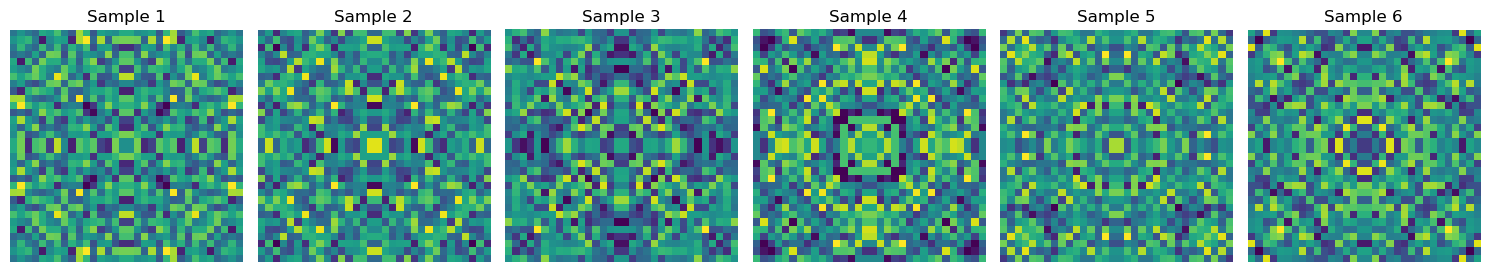

In [3]:
def generate_8fold_symmetric_images(n_images, size=32):
    """
    Generate n_images of size x size with 8-fold symmetry and pixel values 0-1
    
    Args:
        n_images (int): Number of images to generate
        size (int): Size of each image (size x size pixels)
    
    Returns:
        np.ndarray: Array of shape (n_images, size, size) containing the symmetric images
    """
    # Only generate 1/8 of the image, then reflect/rotate for symmetry
    sector_size = size // 2
    sector = np.random.rand(n_images, sector_size, sector_size)
    
    # Create full images
    images = np.zeros((n_images, size, size))
    
    for i in range(n_images):
        # Create base quadrant
        quadrant = np.concatenate([sector[i], np.fliplr(sector[i])], axis=1)
        
        # Create full image with 4-fold symmetry
        full = np.concatenate([quadrant, np.flipud(quadrant)], axis=0)
        
        # Add diagonal symmetry by averaging with transpose
        symmetric = (full + full.T) / 2
        
        images[i] = symmetric
        
    return images

# Generate example images
n_samples = 6
symmetric_images = generate_8fold_symmetric_images(n_samples)

# Visualize some examples
fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(symmetric_images[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')
plt.tight_layout()
plt.show()


C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\1179357256.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


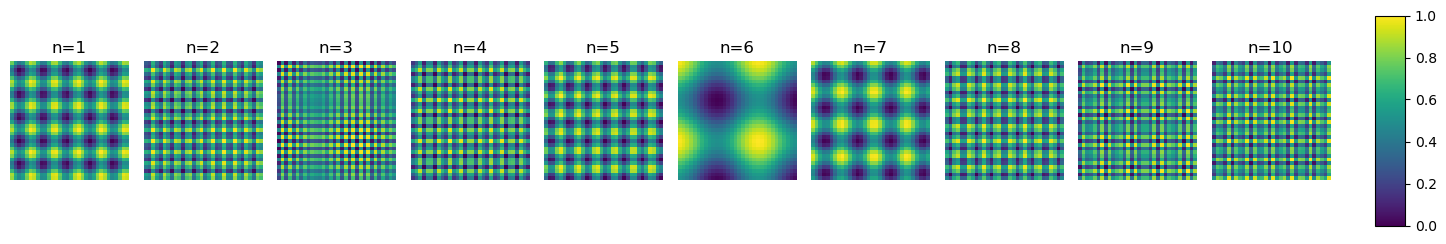

C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\1179357256.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


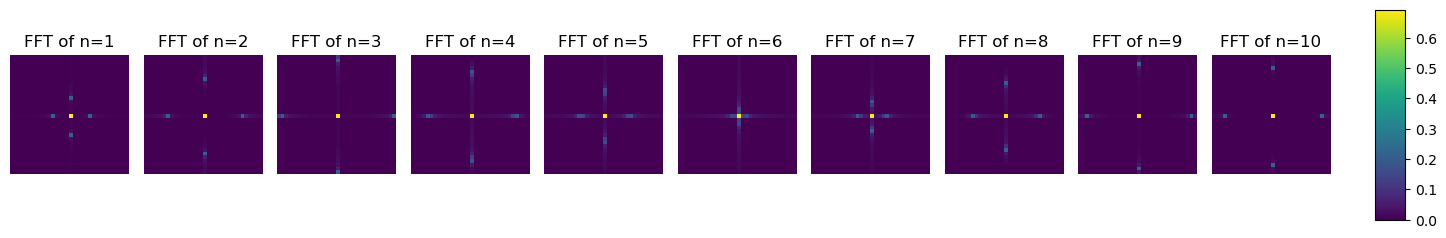

In [4]:
# Create list of integers
integers = list(range(1, 11))

def embed_integer_fourier(n, size=32):
    """
    Embed an integer as a size x size image using Fourier embedding
    
    Args:
        n (int): Integer to embed
        size (int): Size of output image (default 32)
    
    Returns:
        np.ndarray: size x size image embedding of the integer
    """
    # Create coordinate grid from 0 to 31
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)
    
    # Create pattern using cosine product with x+1 and y+1
    scalar = n
    pattern = (np.cos((Y+1)*scalar) + np.cos((X+1)*scalar))/2
    
    # Normalize to 0-1 range
    pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min())
    
    return pattern

# Generate embeddings for each integer
fourier_embeddings = np.array([embed_integer_fourier(n) for n in integers])

# Visualize the embeddings
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(fourier_embeddings[i], cmap='viridis')
    images.append(im)
    ax.axis('off')
    ax.set_title(f'n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Compute and visualize the Fourier transforms of the embeddings
fourier_transforms = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) for embedding in fourier_embeddings])

# Normalize the Fourier transforms for better visualization
fourier_transforms = np.array([(ft - ft.min()) / (ft.max() - ft.min()) for ft in fourier_transforms])

# Plot the Fourier transforms
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(np.log1p(fourier_transforms[i]), cmap='viridis')  # log scale for better visibility
    images.append(im)
    ax.axis('off') 
    ax.set_title(f'FFT of n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\3914231729.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


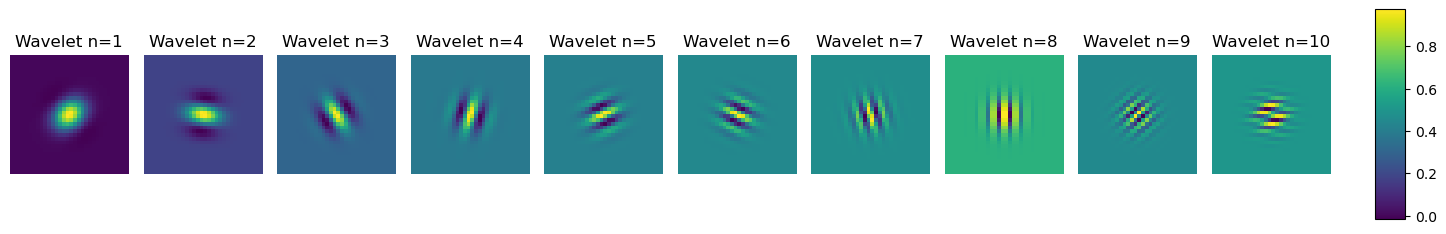

C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\3914231729.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


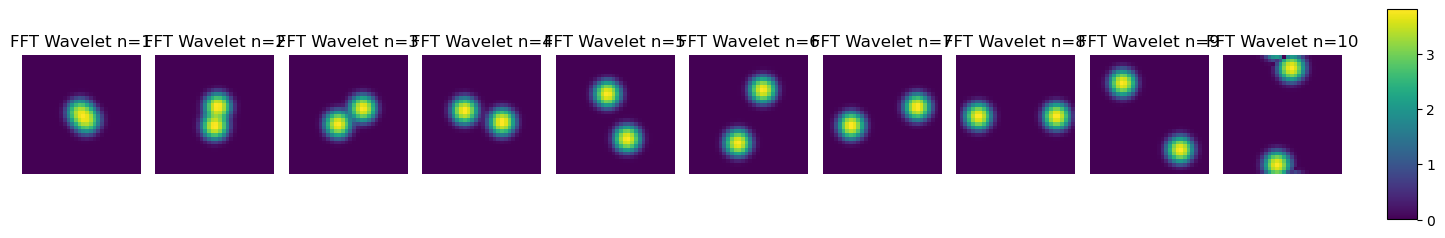


Time domain max values:
n=1: 0.9742
n=2: 0.9513
n=3: 0.9674
n=4: 0.9167
n=5: 0.9231
n=6: 0.9074
n=7: 0.8700
n=8: 0.8771
n=9: 0.9673
n=10: 0.7851

Frequency domain max values:
n=1: 43.8459
n=2: 28.6162
n=3: 29.5251
n=4: 28.8896
n=5: 29.6295
n=6: 29.4232
n=7: 28.7543
n=8: 28.9008
n=9: 29.7785
n=10: 30.1454


In [29]:
def embed_const_wavelet(s, size=32, freq_range=2.0):
    """
    Embed an integer into a 2D pattern using Gabor wavelets.
    
    Args:
        s: Positive integer to embed 
        size: Size of the square output array
        freq_range: Factor to control the frequency range (higher values = broader frequency range)
    
    Returns:
        2D numpy array with the Gabor wavelet embedding
    """
    # Create coordinate grid
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    
    # Set base frequency based on input scalar s
    # Use size as the fundamental frequency unit instead of pi
    base_frequency = (abs(s)) * (size/8)
    
    # Set orientation (in radians)
    theta = s % 8 * (size/8)  # Vary orientation based on s
    
    # Rotate coordinates
    X_theta = X * np.cos(theta) + Y * np.sin(theta)
    Y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    
    # Gaussian envelope parameters - inversely related to freq_range
    # Higher freq_range means smaller sigma which creates broader frequency spectrum
    sigma_x = 0.4 / freq_range
    sigma_y = 0.4 / freq_range
    
    # Gaussian envelope - smaller sigma creates a more localized wavelet in space
    # which corresponds to a broader frequency spectrum in Fourier domain
    gaussian = np.exp(-(X_theta**2 / (2 * sigma_x**2) + Y_theta**2 / (2 * sigma_y**2)))
    
    # Gabor wavelet (sinusoidal carrier * gaussian envelope)
    gabor = gaussian * np.cos(base_frequency * X_theta)
    
    # Return the pattern without normalizing to preserve values
    return gabor

# Generate wavelet embeddings for each integer
wavelet_embeddings = np.array([embed_const_wavelet(s) for s in integers])

# Visualize the wavelet embeddings
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(wavelet_embeddings[i], cmap='viridis')
    images.append(im)
    ax.axis('off')
    ax.set_title(f'Wavelet n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Compute and visualize the Fourier transforms of the wavelet embeddings
wavelet_fourier = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) for embedding in wavelet_embeddings])

# Normalize the Fourier transforms for better visualization
# wavelet_fourier = np.array([(ft - ft.min()) / (ft.max() - ft.min()) for ft in wavelet_fourier])

# Plot the Fourier transforms of wavelet embeddings
fig, axes = plt.subplots(1, len(integers), figsize=(15, 3), gridspec_kw={'width_ratios': [1]*len(integers)})
images = []
for i, ax in enumerate(axes):
    im = ax.imshow(np.log1p(wavelet_fourier[i]), cmap='viridis')  # log scale for better visibility
    images.append(im)
    ax.axis('off') 
    ax.set_title(f'FFT Wavelet n={integers[i]}')
# Add colorbar in a way that doesn't overlap with the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Print max values for time domain (wavelet embeddings)
print("\nTime domain max values:")
for i, val in enumerate(integers):
    max_val = np.max(np.abs(wavelet_embeddings[i]))
    print(f"n={val}: {max_val:.4f}")

# Print max values for frequency domain
print("\nFrequency domain max values:")
for i, val in enumerate(integers):
    max_val = np.max(wavelet_fourier[i]) 
    print(f"n={val}: {max_val:.4f}")


C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\3972048498.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


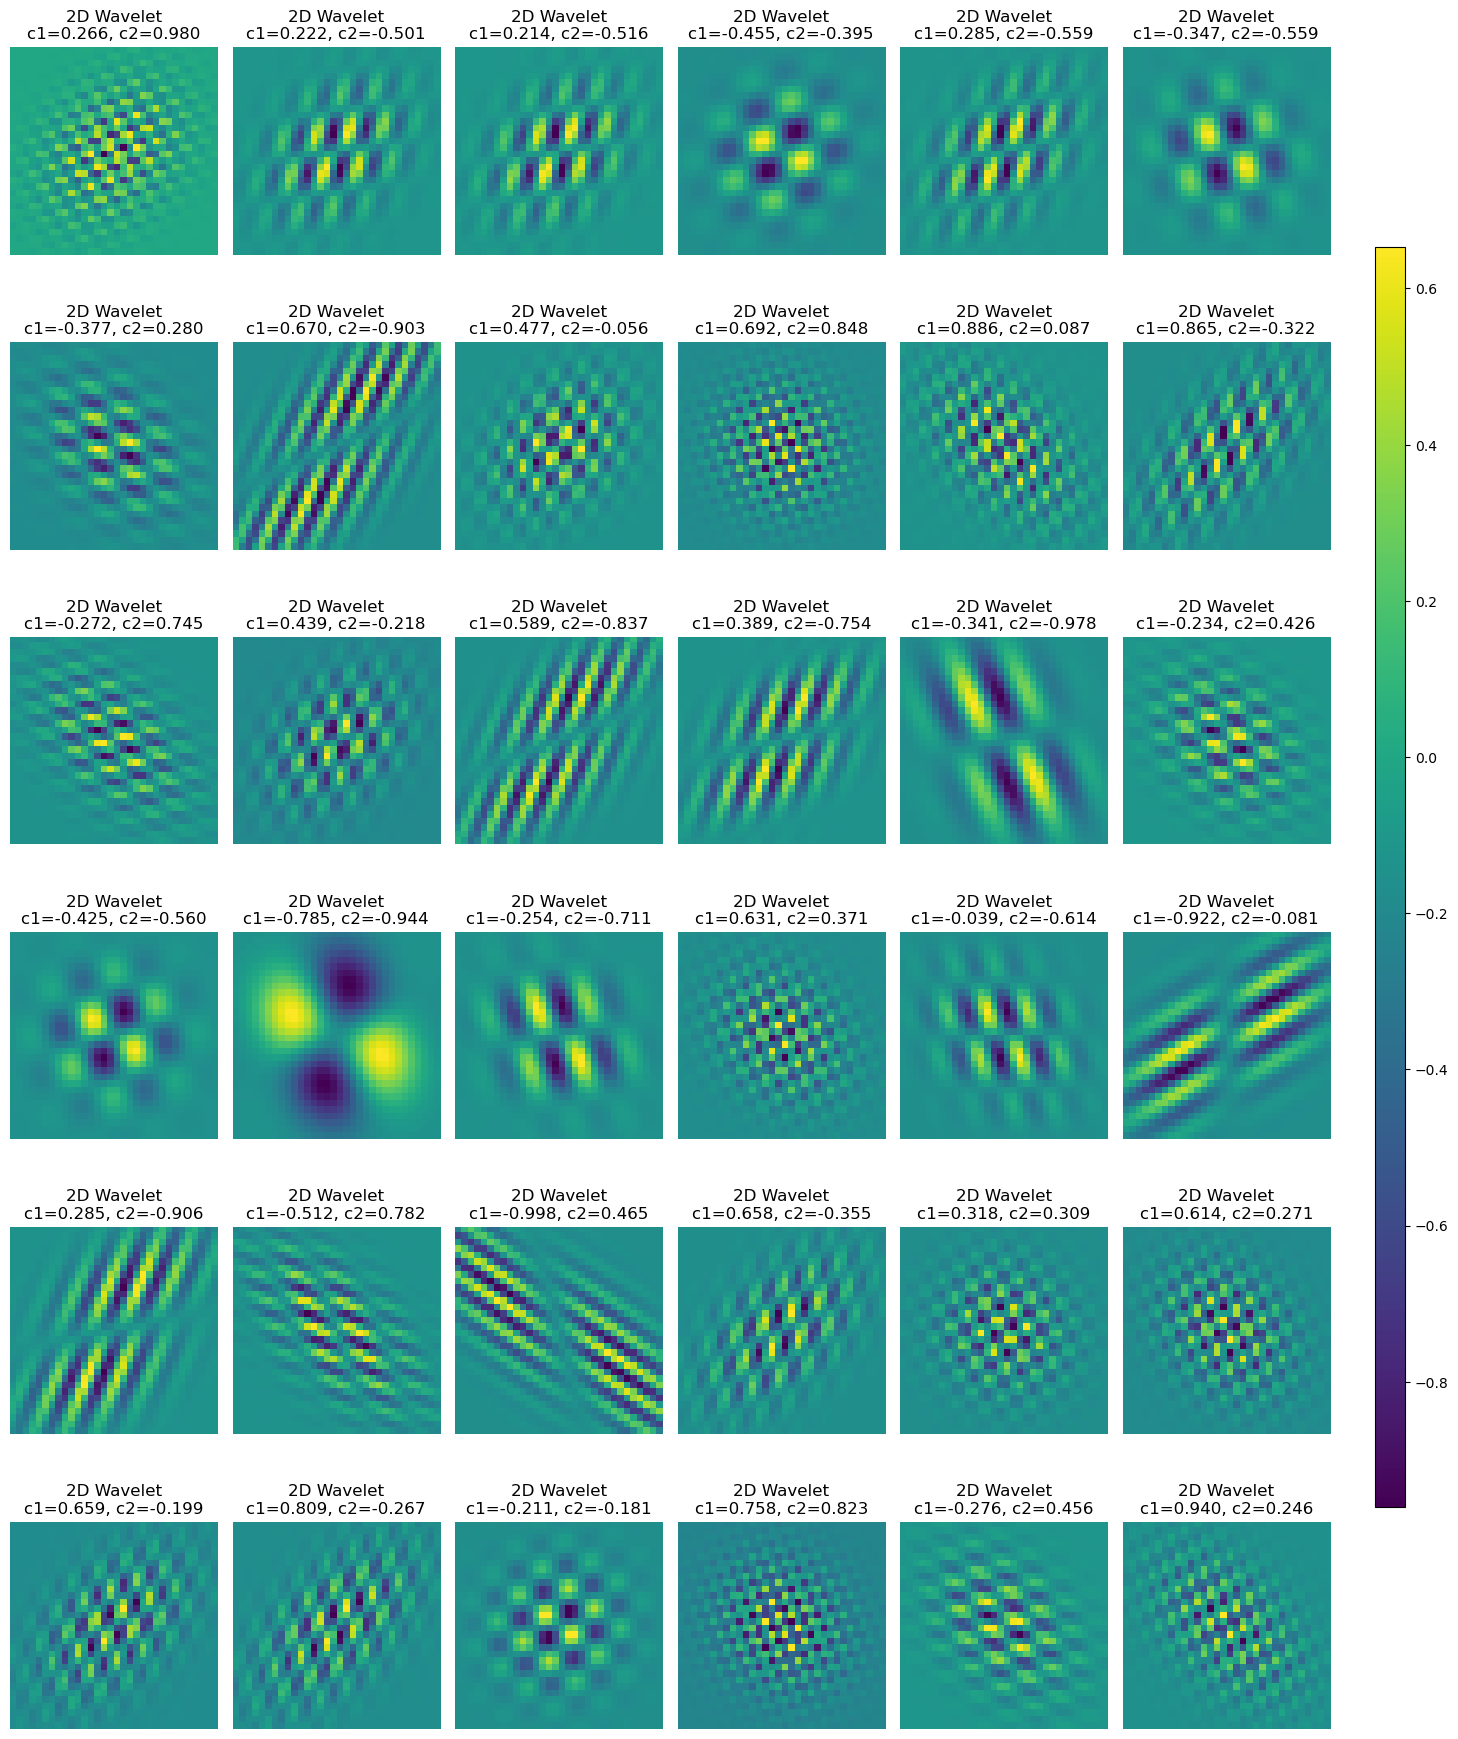

C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\3972048498.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


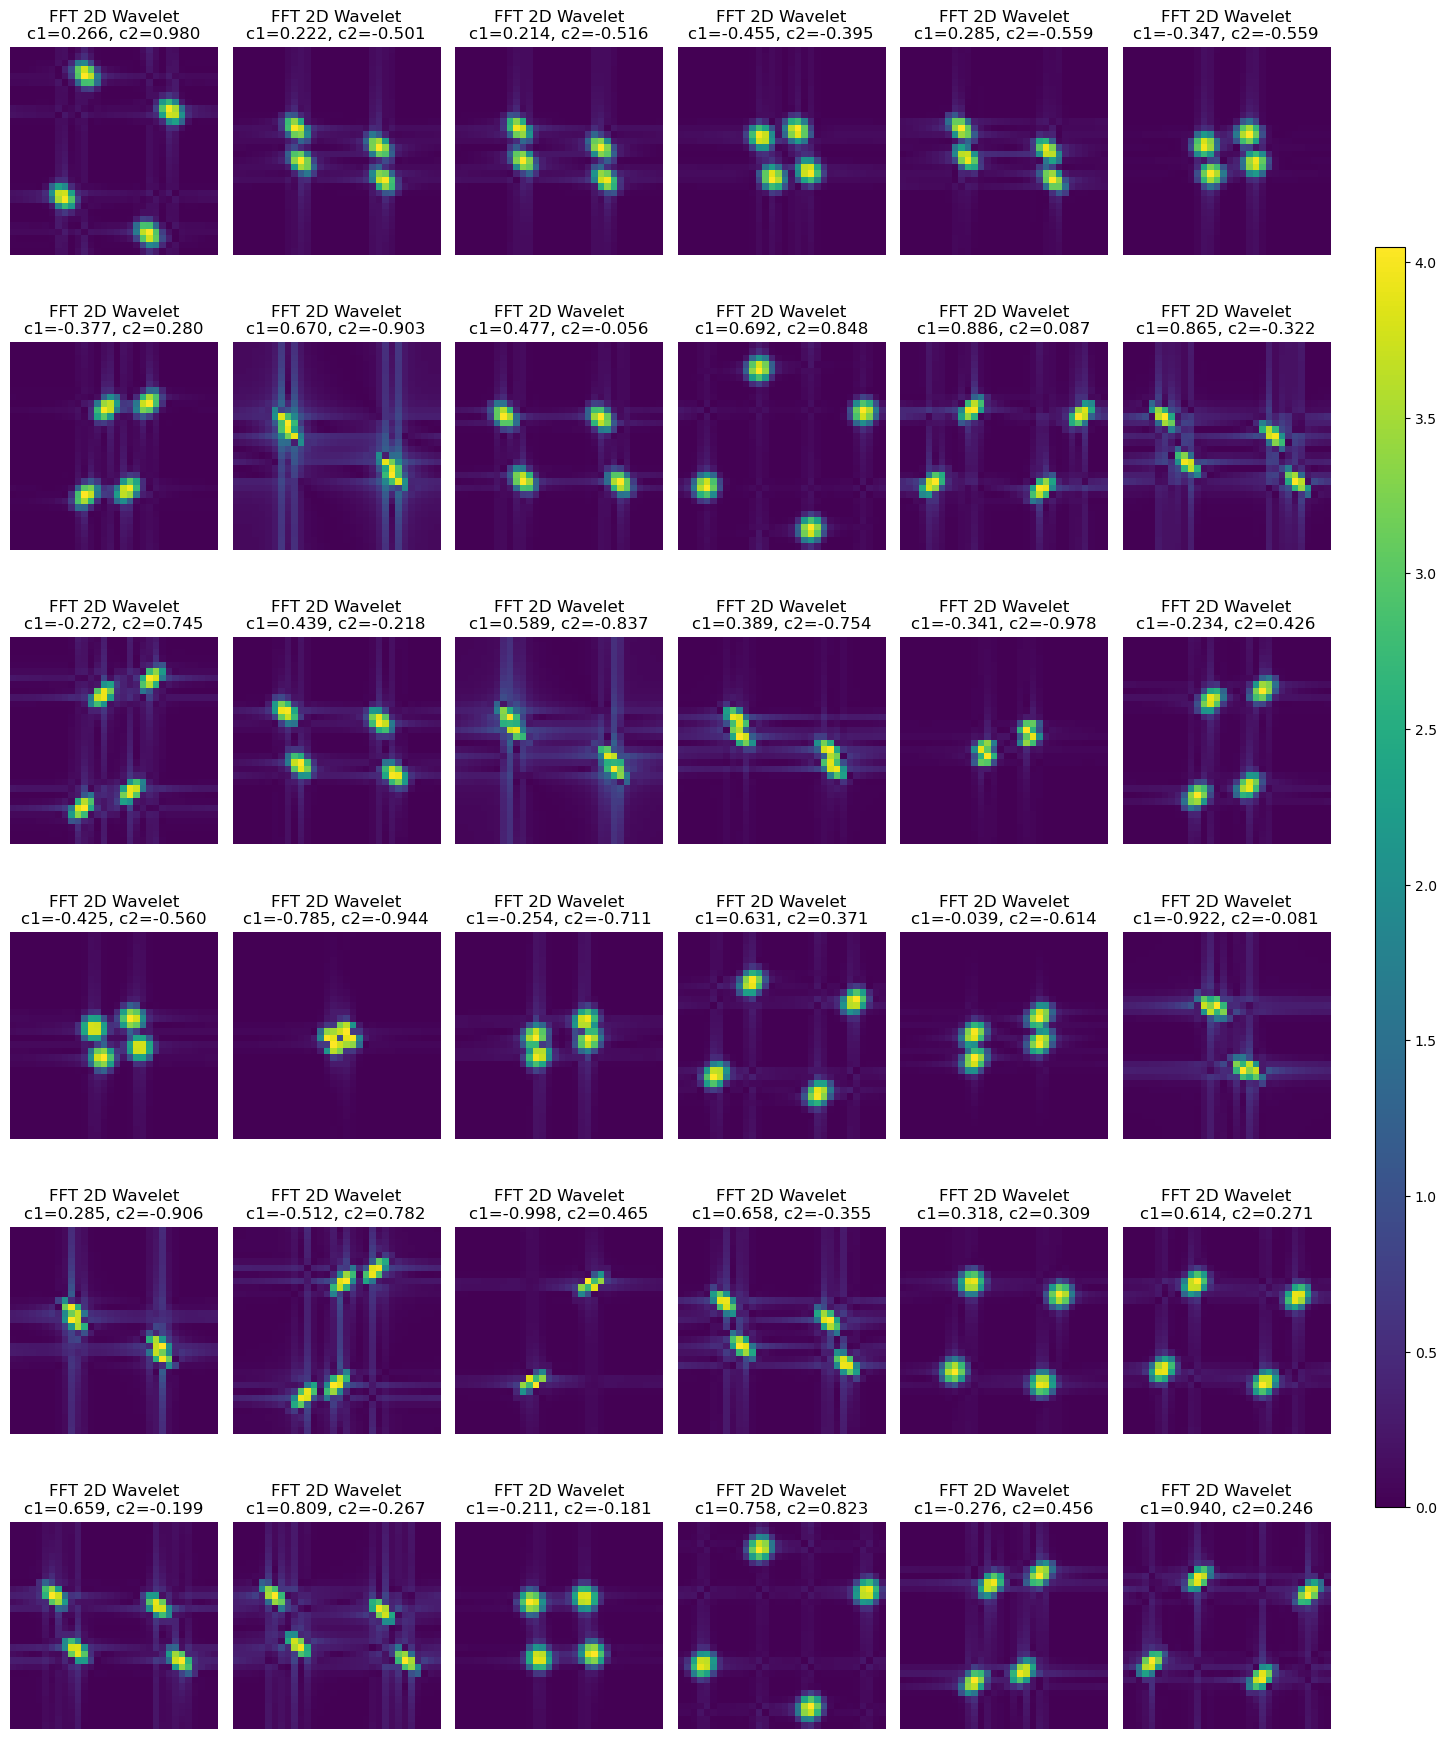

test_embeddings min: -0.961, max: 0.902
test_fourier min: 0.000, max: 67.161


In [54]:
def embed_2const_wavelet(c1, c2, size=32, freq_range=1.0):
    """
    Embed two integers into a 2D pattern using Gabor wavelets with different frequencies in x and y.
    
    Args:
        c1: First integer to embed (controls x frequency and rotation)
        c2: Second integer to embed (controls y frequency and rotation)
        size: Size of the square output array
        freq_range: Factor to control the frequency range (higher values = broader frequency spectrum)
    
    Returns:
        2D numpy array with the 2D Gabor wavelet embedding
    """
    # Create coordinate grid
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    
    # Set base frequencies based on input constants
    freq_x = (1.0 + (c1)) * (size/2)
    freq_y = (1.0 + (c2)) * (size/2)
    
    # Calculate rotation angles based on c1 and c2
    c1_cycles = 5  # Number of cycles in c1
    c2_cycles = 7  # Number of cycles in c2
    theta1 = (c1 % c1_cycles) * (np.pi/c1_cycles)  
    theta2 = (c2 % c2_cycles) * (np.pi/c2_cycles)  
    # theta = theta1 + theta2  # Combine rotations
    
    # Rotate coordinates
    X_rot = X * np.cos(theta1) + Y * np.sin(theta2)
    Y_rot = -X * np.sin(theta1) + Y * np.cos(theta2)
    
    # Gaussian envelope parameters
    sigma_x = 0.4 / freq_range
    sigma_y = 0.4 / freq_range
    
    # Gaussian envelope with rotated coordinates
    gaussian = np.exp(-(X_rot**2 / (2 * sigma_x**2) + Y_rot**2 / (2 * sigma_y**2)))
    
    # 2D Gabor wavelet with separate x and y frequencies on rotated coordinates
    gabor = gaussian * np.sin(freq_x * X_rot) * np.sin(freq_y * Y_rot)
    
    return gabor

# Test the new function with some example values
pi = 1
test_pairs = [(random.random()*2*pi - pi, random.random()*2*pi - pi) for _ in range(36)]
test_embeddings = np.array([embed_2const_wavelet(c1, c2) for c1, c2 in test_pairs])

# Visualize the 2D wavelet embeddings
num_rows = (len(test_pairs) + 5) // 6  # Calculate number of rows needed for 6 plots per row
fig, axes = plt.subplots(num_rows, 6, figsize=(15, 3*num_rows))
axes = axes.flatten()  # Flatten array for easier indexing
images = []

for i, ax in enumerate(axes):
    if i < len(test_pairs):
        im = ax.imshow(test_embeddings[i], cmap='viridis')
        images.append(im)
        ax.axis('off')
        ax.set_title(f'2D Wavelet\nc1={test_pairs[i][0]:.3f}, c2={test_pairs[i][1]:.3f}')
    else:
        ax.axis('off')  # Hide unused subplots

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Compute and visualize the Fourier transforms
test_fourier = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) for embedding in test_embeddings])
# test_fourier = np.array([(ft - ft.min()) / (ft.max() - ft.min()) for ft in test_fourier])

# Plot the Fourier transforms
fig, axes = plt.subplots(num_rows, 6, figsize=(15, 3*num_rows))
axes = axes.flatten()
images = []

for i, ax in enumerate(axes):
    if i < len(test_pairs):
        im = ax.imshow(np.log1p(test_fourier[i]), cmap='viridis')
        images.append(im)
        ax.axis('off')
        ax.set_title(f'FFT 2D Wavelet\nc1={test_pairs[i][0]:.3f}, c2={test_pairs[i][1]:.3f}')
    else:
        ax.axis('off')  # Hide unused subplots

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print(f"test_embeddings min: {test_embeddings.min():.3f}, max: {test_embeddings.max():.3f}")
print(f"test_fourier min: {test_fourier.min():.3f}, max: {test_fourier.max():.3f}")


C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\4204739974.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


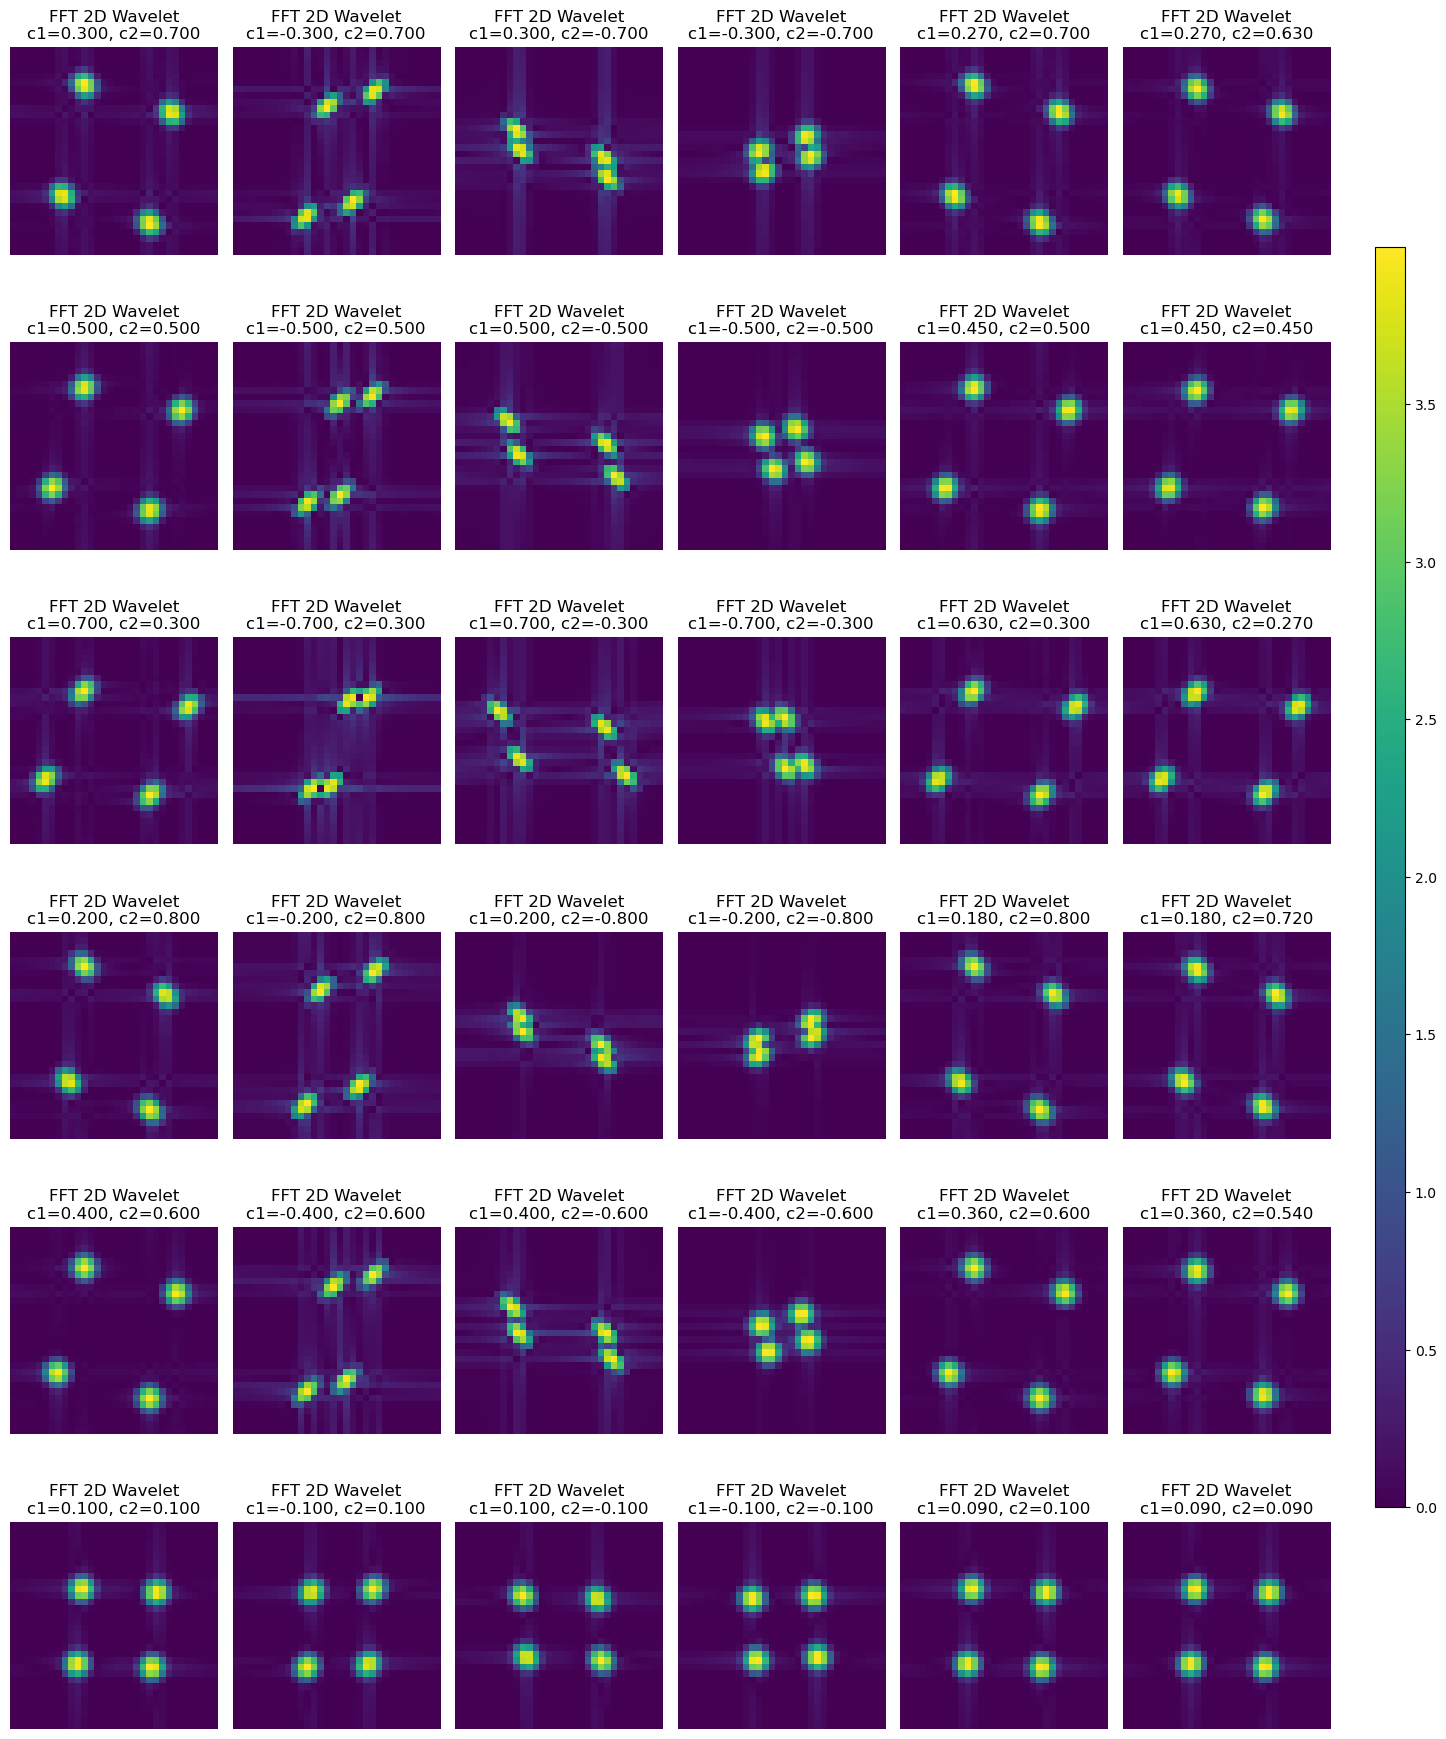

C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\4204739974.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


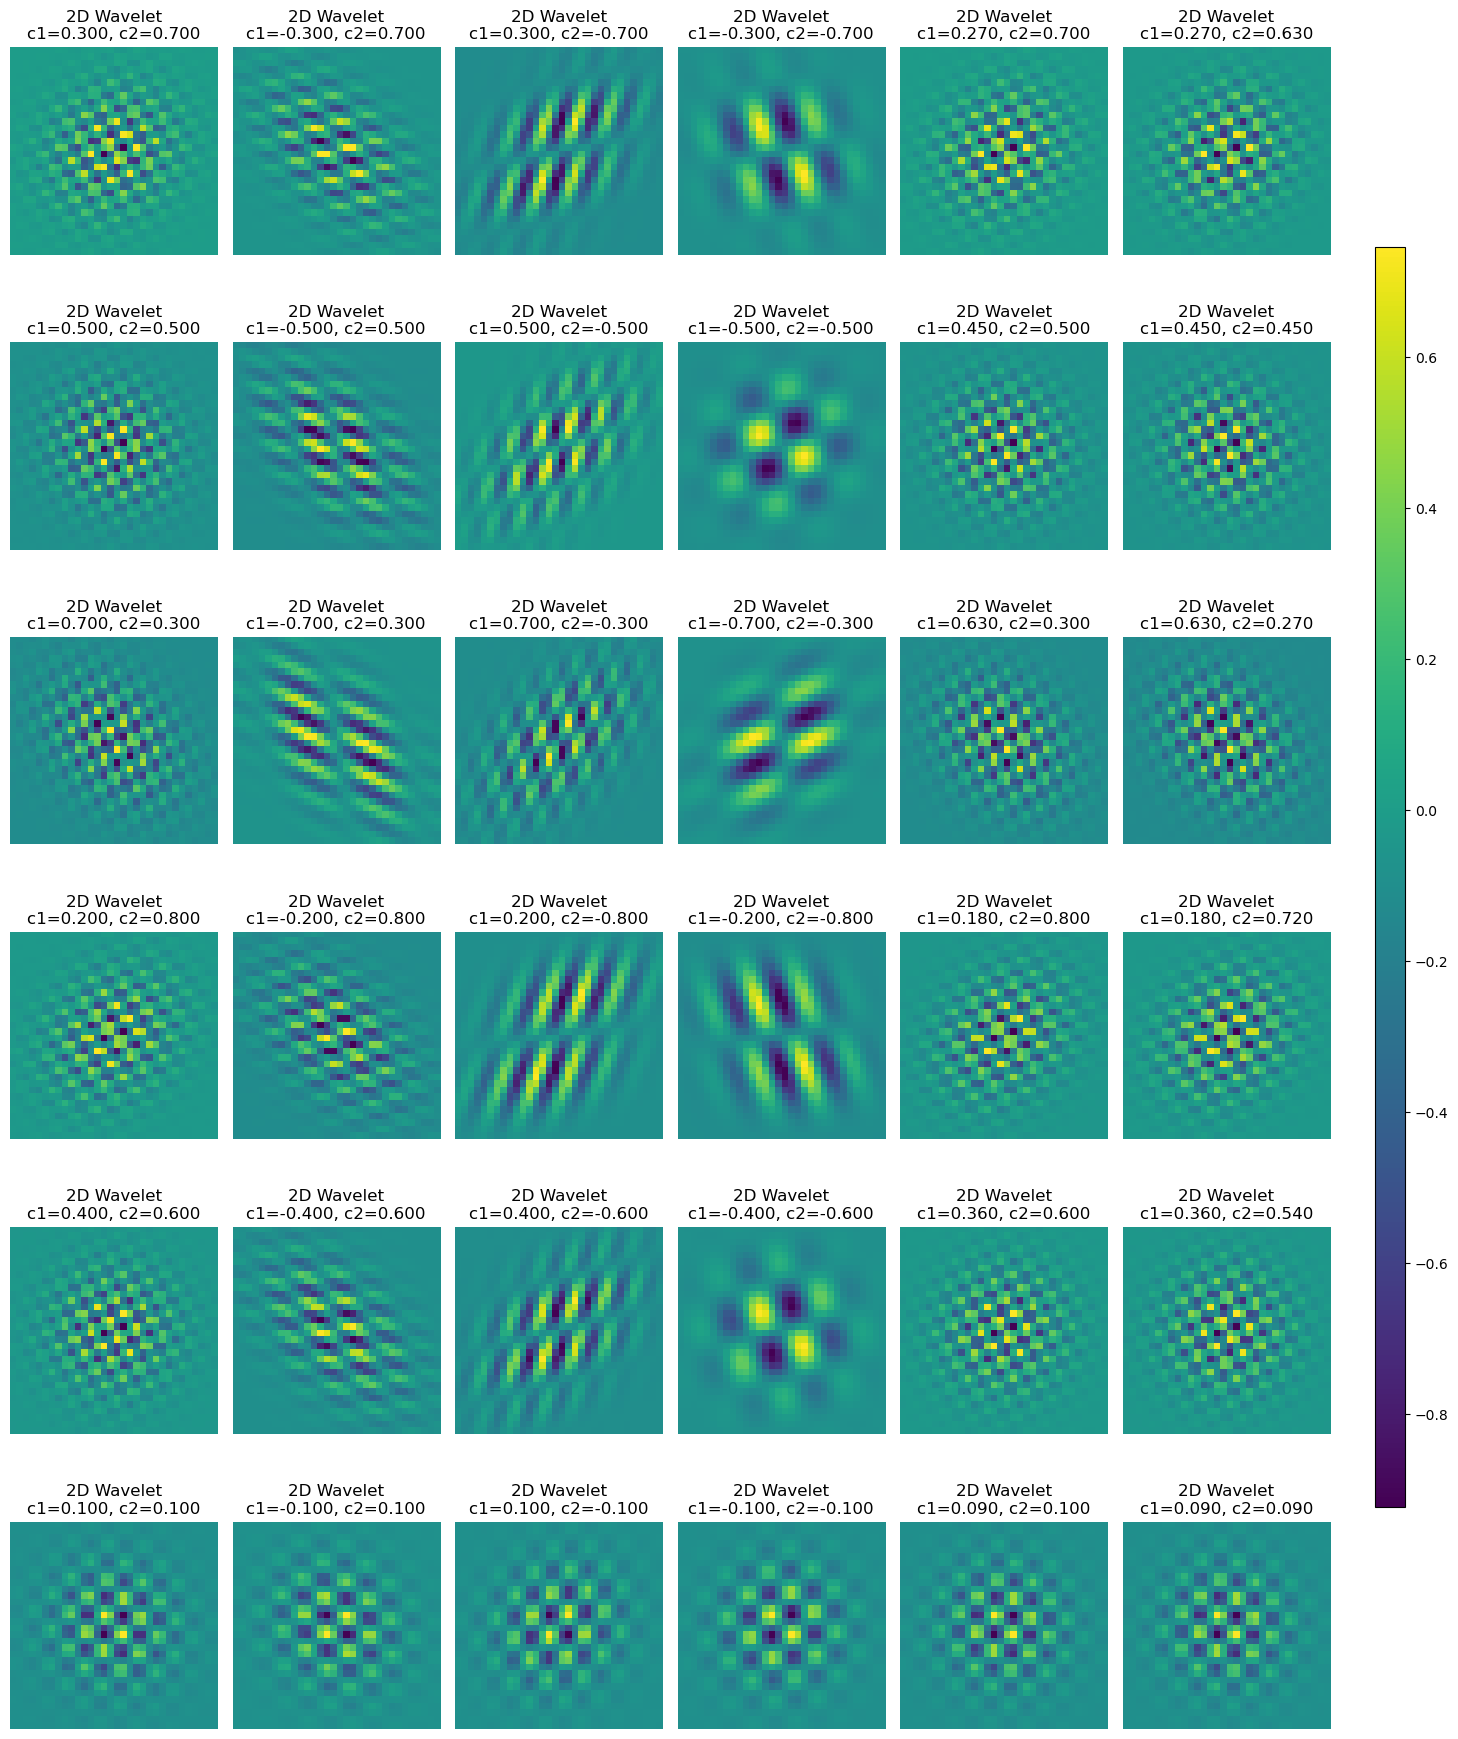

test_embeddings min: -0.925, max: 0.928
test_fourier min: 0.000, max: 65.670


In [55]:
# Choose 6 base pairs of c1, c2 values
base_pairs = [
    (0.3, 0.7),
    (0.5, 0.5), 
    (0.7, 0.3),
    (0.2, 0.8),
    (0.4, 0.6),
    (0.1, 0.1)
]

# Generate augmented pairs by applying transformations
test_pairs = []
for c1, c2 in base_pairs:
    # Original pair
    test_pairs.append((c1, c2))
    # Negated pairs
    test_pairs.append((-c1, c2))
    test_pairs.append((c1, -c2))
    test_pairs.append((-c1, -c2))
    # Scaled pairs
    test_pairs.append((0.9*c1, c2))
    test_pairs.append((0.9*c1, 0.9*c2))

test_pairs = np.array(test_pairs)
num_rows = int(np.ceil(len(test_pairs) / 6))

# Generate embeddings for all pairs
test_embeddings = np.array([embed_2const_wavelet(c1, c2) for c1, c2 in test_pairs])
# Compute and visualize the Fourier transforms
test_fourier = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) for embedding in test_embeddings])
# test_fourier = np.array([(ft - ft.min()) / (ft.max() - ft.min()) for ft in test_fourier])

# Plot the Fourier transforms
fig, axes = plt.subplots(num_rows, 6, figsize=(15, 3*num_rows))
axes = axes.flatten()
images = []

for i, ax in enumerate(axes):
    if i < len(test_pairs):
        im = ax.imshow(np.log1p(test_fourier[i]), cmap='viridis')
        images.append(im)
        ax.axis('off')
        ax.set_title(f'FFT 2D Wavelet\nc1={test_pairs[i][0]:.3f}, c2={test_pairs[i][1]:.3f}')
    else:
        ax.axis('off')  # Hide unused subplots

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Visualize the 2D wavelet embeddings
num_rows = (len(test_pairs) + 5) // 6  # Calculate number of rows needed for 6 plots per row
fig, axes = plt.subplots(num_rows, 6, figsize=(15, 3*num_rows))
axes = axes.flatten()  # Flatten array for easier indexing
images = []

for i, ax in enumerate(axes):
    if i < len(test_pairs):
        im = ax.imshow(test_embeddings[i], cmap='viridis')
        images.append(im)
        ax.axis('off')
        ax.set_title(f'2D Wavelet\nc1={test_pairs[i][0]:.3f}, c2={test_pairs[i][1]:.3f}')
    else:
        ax.axis('off')  # Hide unused subplots

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(images[0], cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print(f"test_embeddings min: {test_embeddings.min():.3f}, max: {test_embeddings.max():.3f}")
print(f"test_fourier min: {test_fourier.min():.3f}, max: {test_fourier.max():.3f}")

C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\4262831768.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


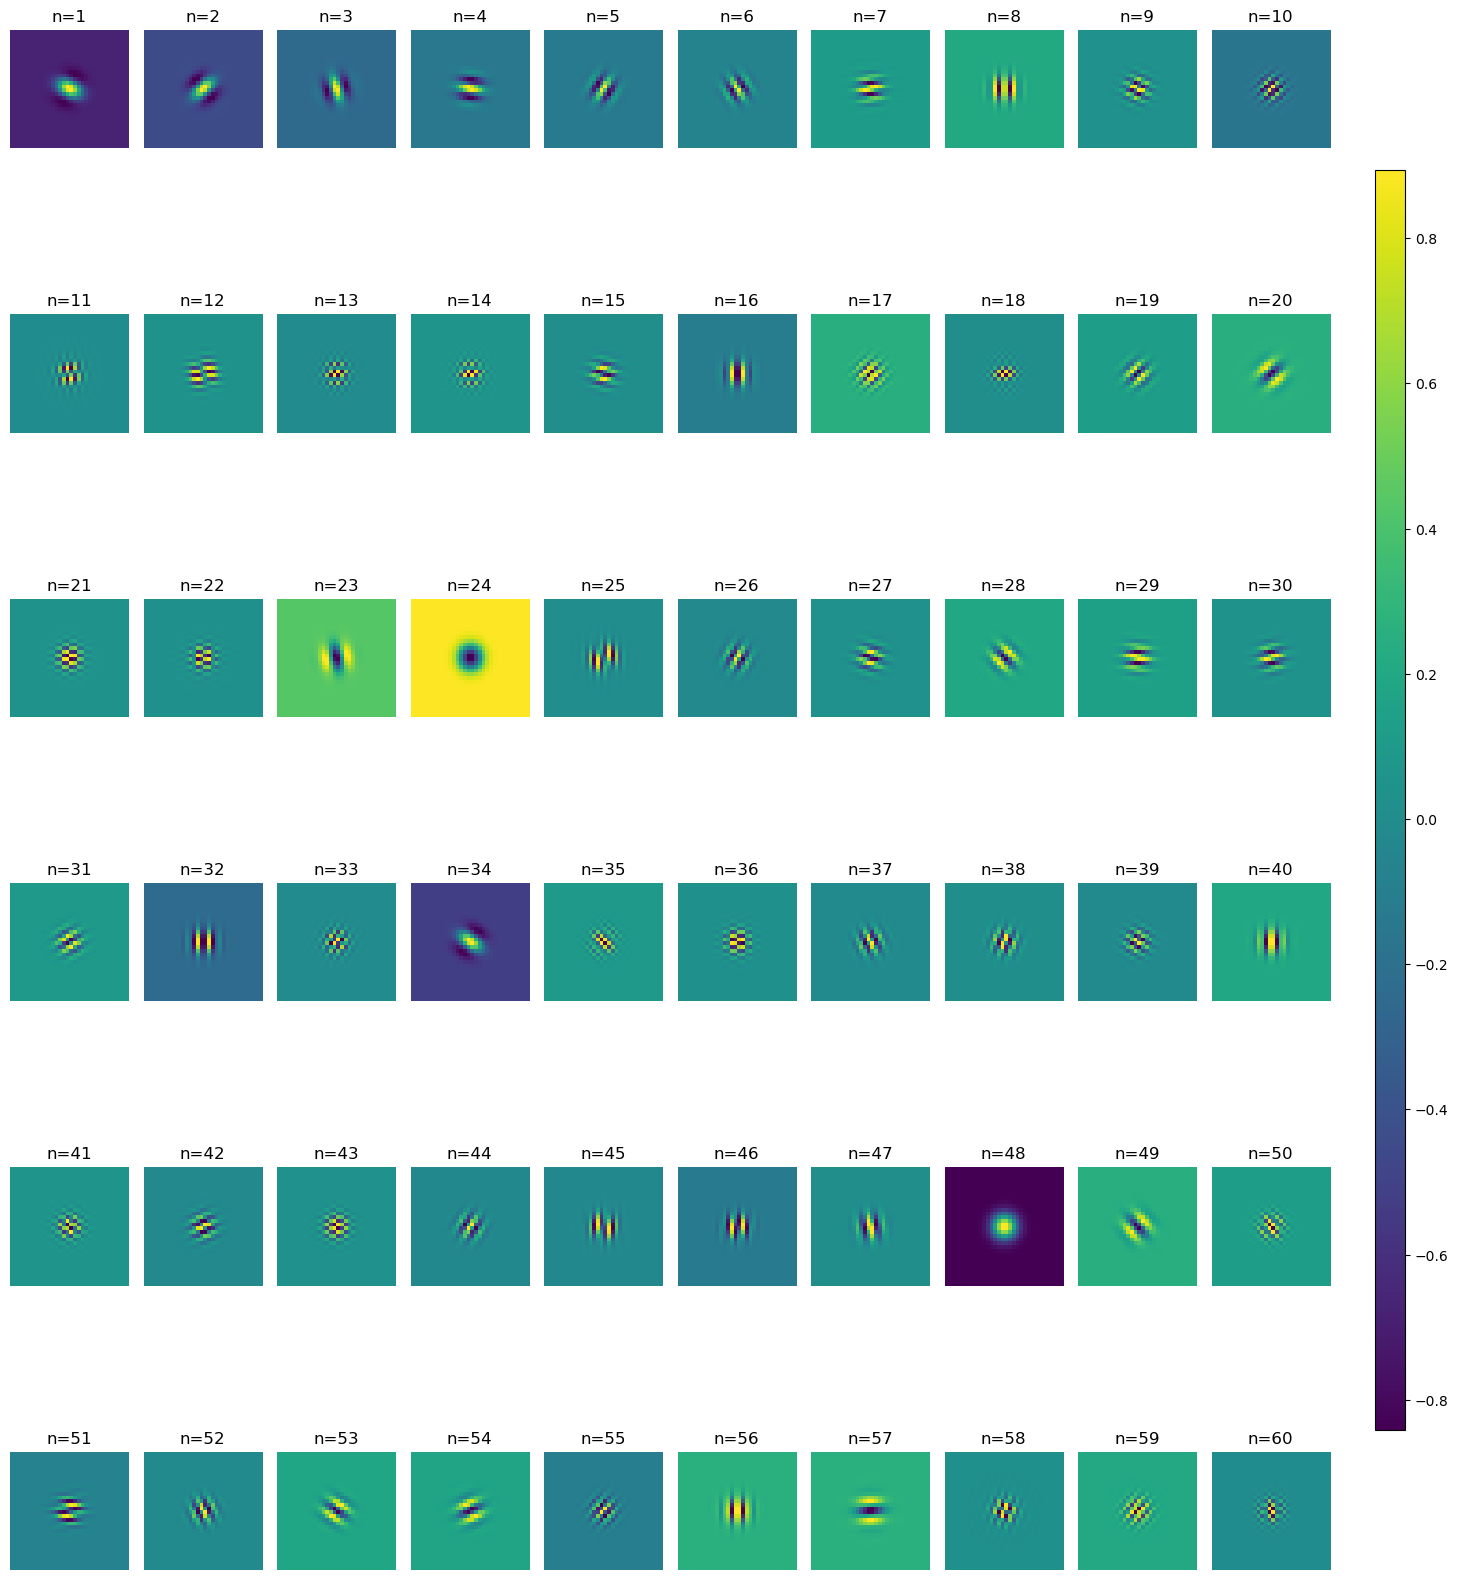

C:\Users\hz283\AppData\Local\Temp\ipykernel_9428\4262831768.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


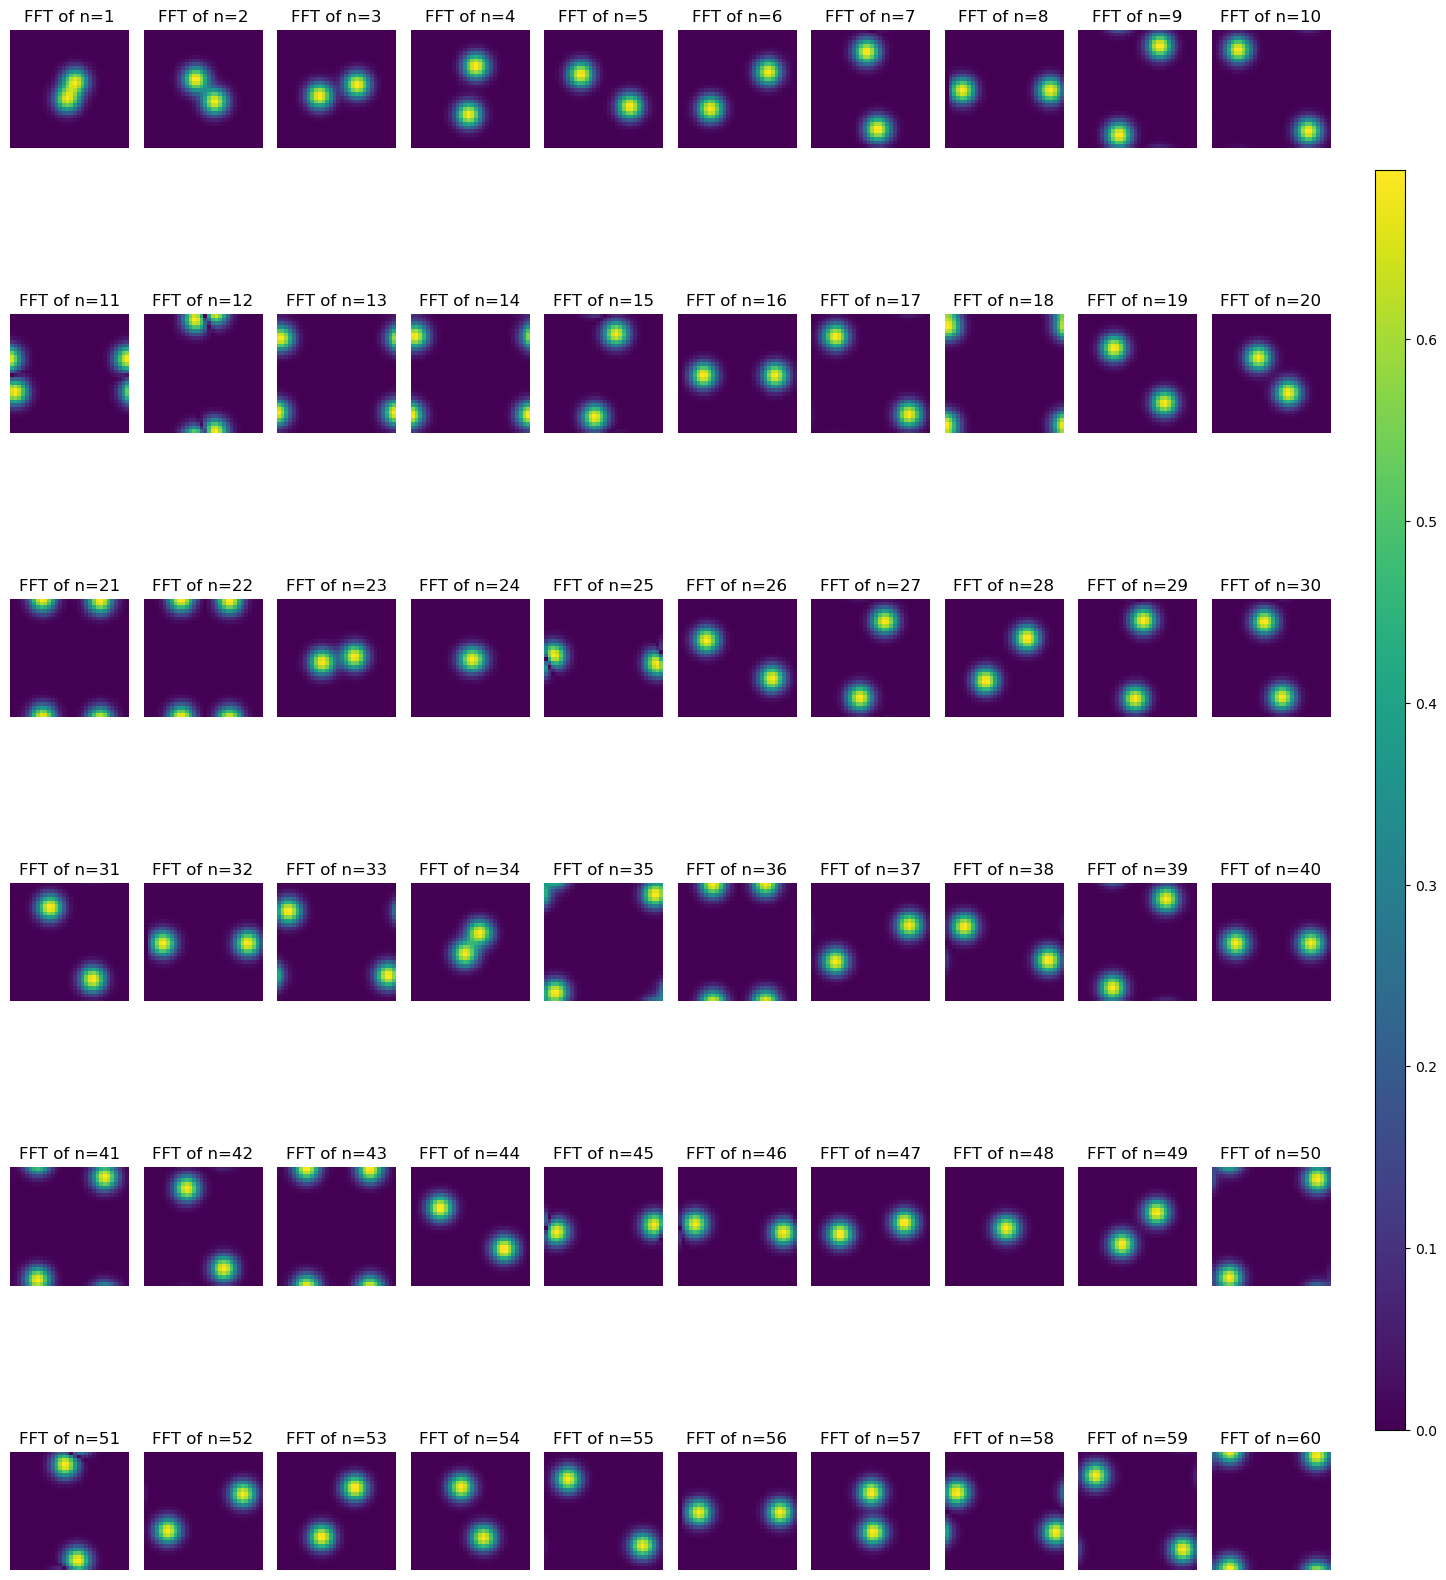

Wavelet Embeddings (Time Domain) Statistics:
Integer 1: Min = -0.1033, Max = 0.9471
Integer 2: Min = -0.2884, Max = 0.9540
Integer 3: Min = -0.4758, Max = 0.8965
Integer 4: Min = -0.5476, Max = 0.8168
Integer 5: Min = -0.6579, Max = 0.9300
Integer 6: Min = -0.7397, Max = 0.9183
Integer 7: Min = -0.7918, Max = 0.6553
Integer 8: Min = -0.7475, Max = 0.4870
Integer 9: Min = -0.7836, Max = 0.7679
Integer 10: Min = -0.5988, Max = 0.9446
Integer 11: Min = -0.7435, Max = 0.7794
Integer 12: Min = -0.5807, Max = 0.5544
Integer 13: Min = -0.7641, Max = 0.8224
Integer 14: Min = -0.8514, Max = 0.7909
Integer 15: Min = -0.7690, Max = 0.7864
Integer 16: Min = -0.5569, Max = 0.7587
Integer 17: Min = -0.9529, Max = 0.5598
Integer 18: Min = -0.9074, Max = 0.9244
Integer 19: Min = -0.9532, Max = 0.7546
Integer 20: Min = -0.9527, Max = 0.5529
Integer 21: Min = -0.6757, Max = 0.6390
Integer 22: Min = -0.7534, Max = 0.7420
Integer 23: Min = -0.8971, Max = 0.3186
Integer 24: Min = -0.9514, Max = 0.0000
Inte

In [6]:
# Generate a 6x10 subplot of wavelet embeddings for integers 1-60
integers_extended = np.arange(1, 61)  # Integers from 1 to 60

# Generate wavelet embeddings for each integer
wavelet_embeddings_extended = np.array([embed_integer_wavelet(s) for s in integers_extended])

# Create a 6x10 grid of subplots for wavelet embeddings
fig, axes = plt.subplots(6, 10, figsize=(15, 18))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each wavelet embedding
for i, ax in enumerate(axes):
    im = ax.imshow(wavelet_embeddings_extended[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'n={integers_extended[i]}')

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Compute the Fourier transforms of the wavelet embeddings
wavelet_fourier_extended = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) 
                                     for embedding in wavelet_embeddings_extended])

# Normalize the Fourier transforms for better visualization
wavelet_fourier_extended = np.array([(ft - ft.min()) / (ft.max() - ft.min()) 
                                     for ft in wavelet_fourier_extended])

# Create a 6x10 grid of subplots for FFT of wavelet embeddings
fig, axes = plt.subplots(6, 10, figsize=(15, 18))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each FFT
for i, ax in enumerate(axes):
    im = ax.imshow(np.log1p(wavelet_fourier_extended[i]), cmap='viridis')  # log scale for better visibility
    ax.axis('off')
    ax.set_title(f'FFT of n={integers_extended[i]}')

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

# Calculate and print the min and max values for both time and frequency domain representations
print("Wavelet Embeddings (Time Domain) Statistics:")
for i, embedding in enumerate(wavelet_embeddings_extended):
    print(f"Integer {integers_extended[i]}: Min = {embedding.min():.4f}, Max = {embedding.max():.4f}")

print("\nWavelet Fourier Transforms (Frequency Domain) Statistics:")
# Using the original Fourier transforms before normalization
wavelet_fourier_raw = np.array([np.fft.fftshift(np.abs(np.fft.fft2(embedding))) 
                               for embedding in wavelet_embeddings_extended])
for i, ft in enumerate(wavelet_fourier_raw):
    print(f"Integer {integers_extended[i]}: Min = {ft.min():.4f}, Max = {ft.max():.4f}")

# Summary statistics
print("\nSummary Statistics:")
print(f"Time Domain - Overall Min: {wavelet_embeddings_extended.min():.4f}, Overall Max: {wavelet_embeddings_extended.max():.4f}")
print(f"Frequency Domain - Overall Min: {wavelet_fourier_raw.min():.4f}, Overall Max: {wavelet_fourier_raw.max():.4f}")


Calculating cross-correlation for 60 embeddings...

Highest cross-correlation found between:
Integer 37 and Integer 52
Correlation value: 0.996875


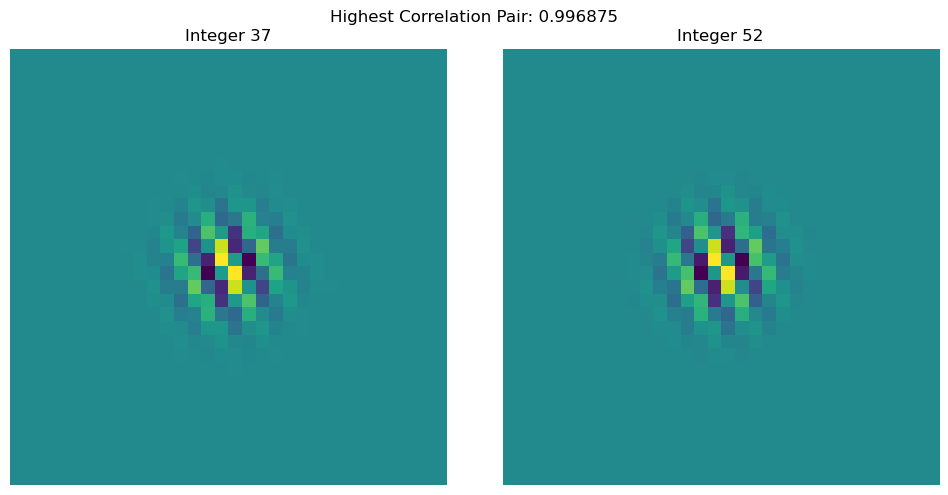

In [7]:
# Calculate cross-correlation between all pairs of wavelet embeddings
import itertools
from scipy import signal

# Get the number of embeddings
n_embeddings = len(wavelet_embeddings_extended)
print(f"Calculating cross-correlation for {n_embeddings} embeddings...")

# Initialize variables to track the highest correlation
highest_corr = 0
highest_pair = (0, 0)

# Iterate through all unique pairs
for i, j in itertools.combinations(range(n_embeddings), 2):
    # Calculate the 2D cross-correlation
    corr = signal.correlate2d(
        wavelet_embeddings_extended[i], 
        wavelet_embeddings_extended[j], 
        mode='same'
    )
    
    # Get the maximum correlation value
    max_corr = np.max(corr)
    
    # Normalize by the autocorrelations
    auto_corr_i = np.max(signal.correlate2d(
        wavelet_embeddings_extended[i], 
        wavelet_embeddings_extended[i], 
        mode='same'
    ))
    auto_corr_j = np.max(signal.correlate2d(
        wavelet_embeddings_extended[j], 
        wavelet_embeddings_extended[j], 
        mode='same'
    ))
    
    normalized_corr = max_corr / np.sqrt(auto_corr_i * auto_corr_j)
    
    # Update if this is the highest correlation so far
    if normalized_corr > highest_corr:
        highest_corr = normalized_corr
        highest_pair = (i, j)

# Print the results
print(f"\nHighest cross-correlation found between:")
print(f"Integer {integers_extended[highest_pair[0]]} and Integer {integers_extended[highest_pair[1]]}")
print(f"Correlation value: {highest_corr:.6f}")

# Visualize the two embeddings with highest correlation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first embedding
axes[0].imshow(wavelet_embeddings_extended[highest_pair[0]], cmap='viridis')
axes[0].set_title(f'Integer {integers_extended[highest_pair[0]]}')
axes[0].axis('off')

# Plot the second embedding
axes[1].imshow(wavelet_embeddings_extended[highest_pair[1]], cmap='viridis')
axes[1].set_title(f'Integer {integers_extended[highest_pair[1]]}')
axes[1].axis('off')

plt.suptitle(f'Highest Correlation Pair: {highest_corr:.6f}')
plt.tight_layout()
plt.show()


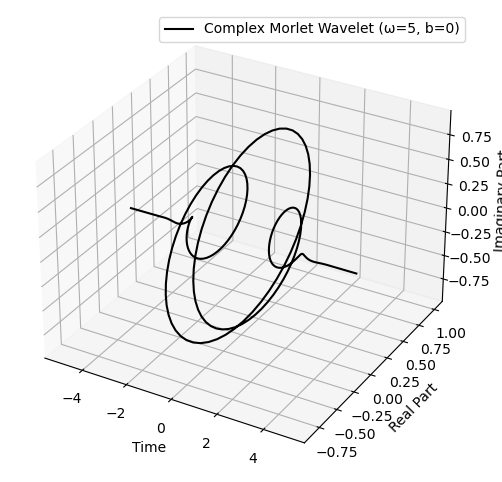

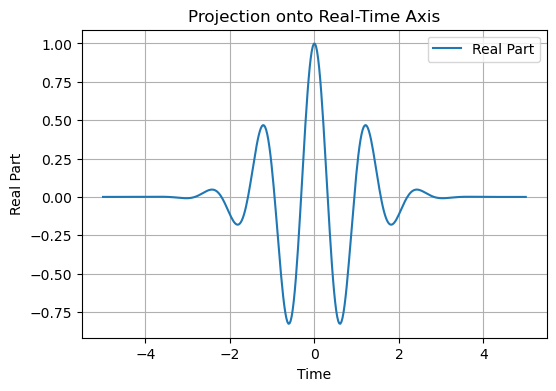

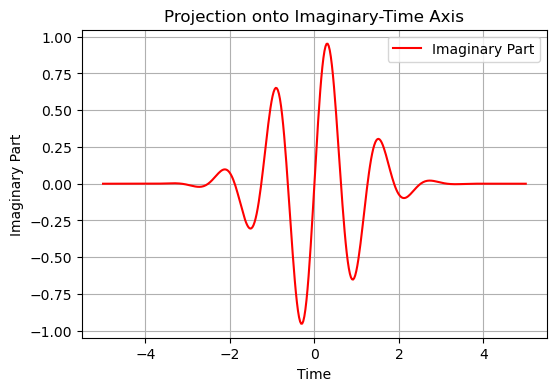

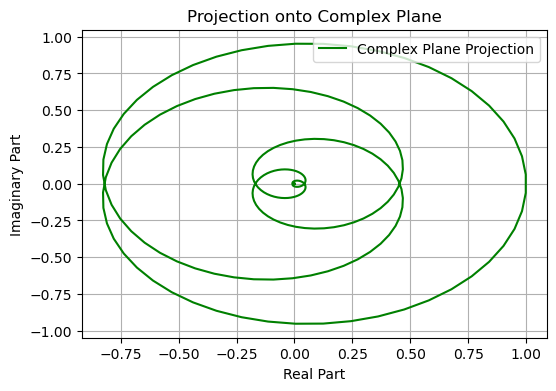

In [25]:
def morlet_wavelet(t, omega=5, b=0):
    return np.exp(1j * omega * (t - b)) * np.exp(-0.5 * (t - b) ** 2)

def plot_morlet_3d(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(t, np.real(wavelet), np.imag(wavelet), label=f'Complex Morlet Wavelet (ω={omega}, b={b})', color='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('Real Part')
    ax.set_zlabel('Imaginary Part')
    ax.legend()
    
    plt.show()

def plot_real_projection(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    plt.figure(figsize=(6, 4))
    plt.plot(t, np.real(wavelet), label='Real Part')
    plt.xlabel('Time')
    plt.ylabel('Real Part')
    plt.title('Projection onto Real-Time Axis')
    plt.legend()
    plt.grid()
    plt.show()

def plot_imag_projection(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    plt.figure(figsize=(6, 4))
    plt.plot(t, np.imag(wavelet), label='Imaginary Part', color='r')
    plt.xlabel('Time')
    plt.ylabel('Imaginary Part')
    plt.title('Projection onto Imaginary-Time Axis')
    plt.legend()
    plt.grid()
    plt.show()

def plot_complex_plane_projection(omega=5, b=0):
    t = np.linspace(-5, 5, 400)
    wavelet = morlet_wavelet(t, omega, b)
    
    plt.figure(figsize=(6, 4))
    plt.plot(np.real(wavelet), np.imag(wavelet), label='Complex Plane Projection', color='g')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Projection onto Complex Plane')
    plt.legend()
    plt.grid()
    plt.show()

# Example call with default values
plot_morlet_3d()
plot_real_projection()
plot_imag_projection()
plot_complex_plane_projection()


In [43]:
def gabor_surface(x, y):
    sigma = 5.0  # standard deviation
    omega = 2.0  # frequency
    return np.exp(-(x**2 + y**2)/(2*sigma**2)) * np.cos(2*np.pi*omega*x)

def test_gabor_uniqueness(num_points=1000):
    # Generate random points
    x1 = np.random.uniform(-10, 10, num_points)
    y1 = np.random.uniform(-10, 10, num_points)
    x2 = np.random.uniform(-10, 10, num_points)
    y2 = np.random.uniform(-10, 10, num_points)
    
    # Calculate values
    z1 = gabor_surface(x1, y1)
    z2 = gabor_surface(x2, y2)
    
    # Check for any equal values
    equal_values = np.isclose(z1, z2, rtol=1e-10, atol=1e-10)
    
    # Print results
    print(f"Number of points tested: {num_points}")
    print(f"Number of equal values found: {np.sum(equal_values)}")
    if np.sum(equal_values) > 0:
        print("First few equal value pairs:")
        for i in range(min(5, np.sum(equal_values))):
            idx = np.where(equal_values)[0][i]
            print(f"Pair 1: ({x1[idx]:.3f}, {y1[idx]:.3f}) -> {z1[idx]:.3f}")
            print(f"Pair 2: ({x2[idx]:.3f}, {y2[idx]:.3f}) -> {z2[idx]:.3f}")

test_gabor_uniqueness(num_points=10000)  # Using 10000 points for better statistical significance

Number of points tested: 10000
Number of equal values found: 0


c1 shape: (8,) c2 shape: (8,)


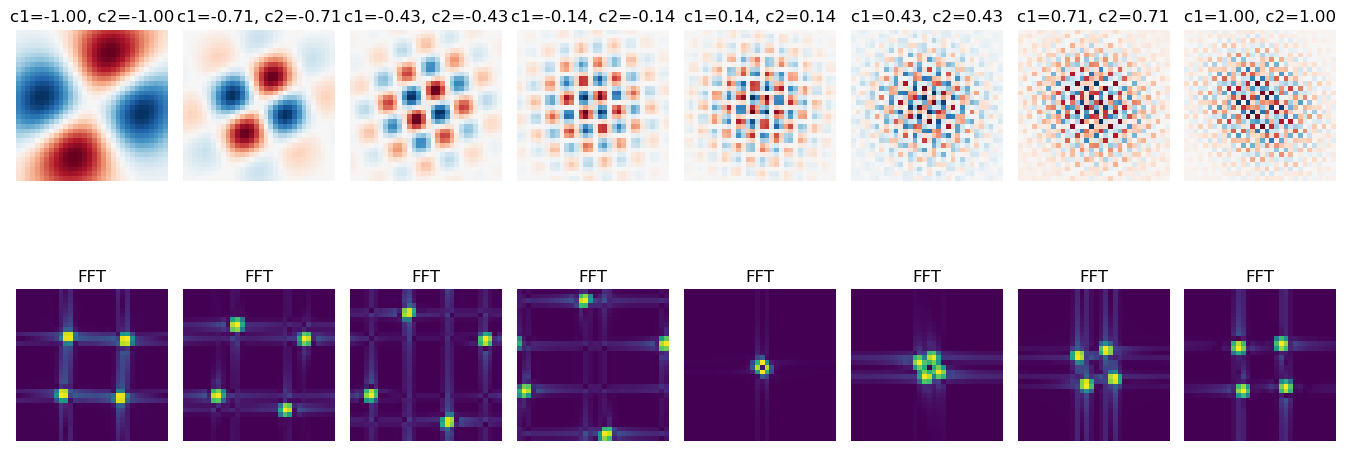

In [7]:
import NO_utils_multiple

n = 8
# Create two vectors of constants ranging from -1 to 1
c1 = np.linspace(-1, 1, n)  # Creates 10 evenly spaced values from -1 to 1
c2 = np.linspace(-1, 1, n)  # Creates 10 evenly spaced values from -1 to 1

util_embeddings = NO_utils_multiple.embed_2const_wavelet(c1,c2, freq_range=0.8)
util_embeddings_fft = np.fft.fftshift(np.abs(np.fft.fft2(util_embeddings)))

# Create a figure with subplots arranged in a grid
n_images = len(util_embeddings)
n_cols = n
n_rows = int(np.ceil(n_images / n_cols)) * 2  # Double the rows for FFT plots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
axes = axes.reshape(2, -1, n_cols)  # Reshape to separate original and FFT plots

# Plot each embedding and its FFT
for i in range(n_images):
    # Original embedding
    im1 = axes[0,i//n_cols,i%n_cols].imshow(util_embeddings[i], cmap='RdBu')
    axes[0,i//n_cols,i%n_cols].set_title(f'c1={c1[i]:.2f}, c2={c2[i]:.2f}')
    axes[0,i//n_cols,i%n_cols].axis('off')
    
    # FFT plot
    im2 = axes[1,i//n_cols,i%n_cols].imshow(np.log(util_embeddings_fft[i] + 1), cmap='viridis')
    axes[1,i//n_cols,i%n_cols].set_title(f'FFT')
    axes[1,i//n_cols,i%n_cols].axis('off')

# Remove empty subplots if any
for row in axes:
    for ax in row.flat[n_images:]:
        fig.delaxes(ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
plt.show()

